In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer,
)
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

In [39]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Lecture 10: Regression metrics

UBC, 2023-24

Instructor: Varada Kolhatkar and Andrew Roth

### Announcements 

- HW4 is due tonight. 
- HW5 will be posted today. It is a project-type homework assignment and will be due after the midterm.  
- Midterm: Thursday, October 26th, 2023 at 6:00pm (~75 mins long)
    - Checkout the midterm information announcement on Piazza (@407)
- No class Thursday for makeup Monday

## Learning outcomes 

From this lecture, students are expected to be able to:

- Carry out feature transformations on somewhat complicated dataset. 
- Visualize transformed features as a dataframe. 
- Use `Ridge` and `RidgeCV`.
- Explain how `alpha` hyperparameter of `Ridge` relates to the fundamental tradeoff. 
- Explain the effect of `alpha` on the magnitude of the learned coefficients. 
- Examine coefficients of transformed features.  
- Appropriately select a scoring metric given a regression problem.
- Interpret and communicate the meanings of different scoring metrics on regression problems.
    - MSE, RMSE, $R^2$, MAPE
- Apply log-transform on the target values in a regression problem with `TransformedTargetRegressor`.

### More comments on tackling class imbalance

- In lecture 9 we talked about a few rather simple approaches to deal with class imbalance. 
- If you have a problem such as fraud detection problem where you want to spot rare events, you can also think of this problem as anomaly detection problem and use different kinds of algorithms such as [isolation forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html).  
- If you are interested in this area, it might be worth checking out this book on this topic.
[Imbalanced Learning: Foundations, Algorithms, and Applications](https://www.amazon.com/dp/1118074629/ref=as_li_ss_tl?&linkCode=sl1&tag=inspiredalgor-20&linkId=615e87a9105582e292ad2b7e2c7ea339&language=en_US)

## Dataset

In this lecture, we'll be using [Kaggle House Prices dataset](https://www.kaggle.com/c/home-data-for-ml-course/). As usual, to run this notebook you'll need to download the data. For this dataset, train and test have already been separated. We'll be working with the train portion in this lecture. 

In [9]:
df = pd.read_csv("../data/housing-kaggle/train.csv")
train_df, test_df = train_test_split(df, test_size=0.10, random_state=123)
train_df.head(n=2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
302,303,20,RL,118.0,13704,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,205000
767,768,50,RL,75.0,12508,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,1300,7,2008,WD,Normal,160000


- The supervised machine learning problem is predicting housing price given features associated with properties. 
- Here, the target is `SalePrice`, which is continuous. So it's a **regression problem** (as opposed to classification).

### Separate $X$ and $y$

In [12]:
X_train = train_df.drop(columns=["SalePrice"])
y_train = train_df["SalePrice"]

X_test = test_df.drop(columns=["SalePrice"])
y_test = test_df["SalePrice"]

### EDA

In [14]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1314.000000,1314.000000,1089.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1307.000000,1314.000000,...,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000
mean,734.182648,56.472603,69.641873,10273.261035,6.076104,5.570015,1970.995434,1984.659056,102.514155,441.425419,...,94.281583,45.765601,21.726788,3.624049,13.987062,3.065449,46.951294,6.302131,2007.840183,179802.147641
std,422.224662,42.036646,23.031794,8997.895541,1.392612,1.112848,30.198127,20.639754,178.301563,459.276687,...,125.436492,65.757545,60.766423,30.320430,53.854129,42.341109,522.283421,2.698206,1.332824,79041.260572
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,369.250000,20.000000,59.000000,7500.000000,5.000000,5.000000,1953.000000,1966.250000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129600.000000
50%,735.500000,50.000000,69.000000,9391.000000,6.000000,5.000000,1972.000000,1993.000000,0.000000,376.000000,...,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162000.000000
75%,1099.750000,70.000000,80.000000,11509.000000,7.000000,6.000000,2000.000000,2004.000000,165.500000,704.750000,...,168.000000,66.750000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,212975.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1378.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1314 entries, 302 to 1389
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1314 non-null   int64  
 1   MSSubClass     1314 non-null   int64  
 2   MSZoning       1314 non-null   object 
 3   LotFrontage    1089 non-null   float64
 4   LotArea        1314 non-null   int64  
 5   Street         1314 non-null   object 
 6   Alley          81 non-null     object 
 7   LotShape       1314 non-null   object 
 8   LandContour    1314 non-null   object 
 9   Utilities      1314 non-null   object 
 10  LotConfig      1314 non-null   object 
 11  LandSlope      1314 non-null   object 
 12  Neighborhood   1314 non-null   object 
 13  Condition1     1314 non-null   object 
 14  Condition2     1314 non-null   object 
 15  BldgType       1314 non-null   object 
 16  HouseStyle     1314 non-null   object 
 17  OverallQual    1314 non-null   int64  
 18  OverallCond

### Feature types 

- We have mixed feature types and a bunch of missing values. 
- Now, let's identify feature types and transformations. 

In [17]:
numeric_looking_columns = X_train.select_dtypes(include=np.number).columns.tolist()
print(numeric_looking_columns)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [18]:
train_df["MSSubClass"].unique()

array([ 20,  50,  30,  60, 160,  85,  90, 120, 180,  80,  70,  75, 190,
        45,  40])

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

In [19]:
train_df["MoSold"].unique()

array([ 1,  7,  3,  5,  8, 10,  6,  9, 12,  2,  4, 11])

In [20]:
drop_features = ["Id"]
numeric_features = [
    "BedroomAbvGr",
    "KitchenAbvGr",
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageYrBlt",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "YrSold",
]

In [22]:
set(numeric_looking_columns) - set(numeric_features) - set(drop_features)

{'MSSubClass', 'MoSold'}

We'll treat the above numeric-looking features as categorical features. 

- There are a bunch of ordinal features in this dataset. 
- Ordinal features with the same scale 
    - Poor (Po), Fair (Fa), Typical (TA), Good (Gd), Excellent (Ex)
    - These we'll be calling `ordinal_features_reg`.
- Ordinal features with different scales
    - These we'll be calling `ordinal_features_oth`.

In [23]:
ordinal_features_reg = [
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "HeatingQC",
    "KitchenQual",
    "FireplaceQu",
    "GarageQual",
    "GarageCond",
    "PoolQC",
]
ordering = [
    "Po",
    "Fa",
    "TA",
    "Gd",
    "Ex",
]  # if N/A it will just impute something, per below
ordering_ordinal_reg = [ordering] * len(ordinal_features_reg)
ordering_ordinal_reg

[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex']]

In [24]:
ordinal_features_oth = [
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "Functional",
    "Fence",
]
ordering_ordinal_oth = [
    ["NA", "No", "Mn", "Av", "Gd"],
    ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
    ["NA", "MnWw", "GdWo", "MnPrv", "GdPrv"],
]

In [25]:
categorical_features = list(
    set(X_train.columns)
    - set(numeric_features)
    - set(ordinal_features_reg)
    - set(ordinal_features_oth)
    - set(drop_features)
)
categorical_features

['SaleCondition',
 'Electrical',
 'LandSlope',
 'Exterior2nd',
 'Alley',
 'SaleType',
 'Foundation',
 'RoofMatl',
 'GarageFinish',
 'MoSold',
 'CentralAir',
 'Utilities',
 'RoofStyle',
 'LotConfig',
 'Condition1',
 'GarageType',
 'MSZoning',
 'Neighborhood',
 'PavedDrive',
 'Exterior1st',
 'HouseStyle',
 'BldgType',
 'MSSubClass',
 'LandContour',
 'Condition2',
 'Street',
 'Heating',
 'MasVnrType',
 'LotShape',
 'MiscFeature']

### Applying feature transformations

- Since we have mixed feature types, let's use `ColumnTransformer` to apply different transformations on different features types.  

In [27]:
from sklearn.compose import ColumnTransformer, make_column_transformer

In [26]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
ordinal_transformer_reg = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_reg),
)
ordinal_transformer_oth = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_oth),
)
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
)

In [ ]:
preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer_reg, ordinal_features_reg),
    (ordinal_transformer_oth, ordinal_features_oth),
    (categorical_transformer, categorical_features),
)

### Examining the preprocessed data

In [28]:
preprocessor.fit(X_train)  # Calling fit to examine all the transformers.
preprocessor.named_transformers_

{'drop': 'drop',
 'pipeline-1': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 'pipeline-2': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                      

In [30]:
ohe_columns = list(
    preprocessor.named_transformers_["pipeline-4"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_features)
)
new_columns = (
    numeric_features + ordinal_features_reg + ordinal_features_oth + ohe_columns
)
X_train_enc = pd.DataFrame(
    preprocessor.transform(X_train), index=X_train.index, columns=new_columns
)
X_train_enc.head()

,BedroomAbvGr,KitchenAbvGr,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,MasVnrType_missing,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_missing
302,0.154795,-0.222647,2.312501,0.381428,0.663680,-0.512408,0.993969,0.840492,0.269972,-0.961498,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
767,1.372763,-0.222647,0.260890,0.248457,-0.054669,1.285467,-1.026793,0.016525,-0.573129,0.476092,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
429,0.154795,-0.222647,2.885044,0.131607,-0.054669,-0.512408,0.563314,0.161931,-0.573129,1.227559,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1139,0.154795,-0.222647,1.358264,-0.171468,-0.773017,-0.512408,-1.689338,-1.679877,-0.573129,0.443419,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
558,0.154795,-0.222647,-0.597924,1.289541,0.663680,-0.512408,0.828332,0.598149,-0.573129,0.354114,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [31]:
X_train.shape, X_train_enc.shape

((1314, 80), (1314, 262))

## Baseline

In [33]:
dummy = DummyRegressor()
pd.DataFrame(cross_validate(dummy, X_train, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.002080,0.000552,-0.003547,0.0
1,0.001431,0.000638,-0.001266,0.0
2,0.001346,0.000586,-0.011767,0.0
3,0.001400,0.000410,-0.006744,0.0
4,0.001625,0.000394,-0.076533,0.0
5,0.001071,0.000363,-0.003133,0.0
6,0.001070,0.000391,-0.000397,0.0
7,0.001025,0.000370,-0.003785,0.0
8,0.000978,0.000345,-0.001740,0.0
9,0.000968,0.000340,-0.000117,0.0


## Ridge regression

In [34]:
lr = make_pipeline(preprocessor, Ridge())
lr.fit(X_train, y_train);

In [35]:
lr_preds = lr.predict(X_test)
lr_preds[:10]

array([224865.34161762,  65243.29045704, 133337.46729488, 250900.65424895,
       128984.32127053, 205597.8361313 , 334576.71199006, 158982.7234503 ,
       148343.09009799, 129257.94933723])

In [36]:
print("Smallest coefficient: ", lr.named_steps["ridge"].coef_.min())
print("Largest coefficient:", lr.named_steps["ridge"].coef_.max())

Smallest coefficient:  -191169.07174468998
Largest coefficient: 83603.0131199608


In [37]:
lr_pipe = make_pipeline(preprocessor, Ridge())
pd.DataFrame(cross_validate(lr_pipe, X_train, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.048978,0.012691,0.862432,0.911846
1,0.045571,0.013994,0.812363,0.913849
2,0.046487,0.014046,0.775270,0.915952
3,0.046409,0.014055,0.874532,0.910843
4,0.057053,0.016224,0.852104,0.911615
5,0.054097,0.016421,0.826142,0.910174
6,0.056174,0.015556,0.825697,0.913767
7,0.052267,0.015929,0.873704,0.910018
8,0.053147,0.015996,0.196599,0.921438
9,0.054608,0.015318,0.890457,0.908215


### Tuning `alpha` hyperparameter of `Ridge`
- Recall that `Ridge` has a hyperparameter `alpha` that controls the fundamental tradeoff.
- This is like `C` in `LogisticRegression` but, annoyingly, `alpha` is the inverse of `C`.
- That is, large `C` is like small `alpha` and vice versa.
- Smaller `alpha`: lower training error (overfitting)

In [40]:
param_grid = {"ridge__alpha": 10.0 ** np.arange(-5, 5, 1)}

pipe_ridge = make_pipeline(preprocessor, Ridge())

search = GridSearchCV(pipe_ridge, param_grid, return_train_score=True, n_jobs=-1)
search.fit(X_train, y_train)
train_scores = search.cv_results_["mean_train_score"]
cv_scores = search.cv_results_["mean_test_score"]

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarn

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarn

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed 

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarn

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarn

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: Fut

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarn

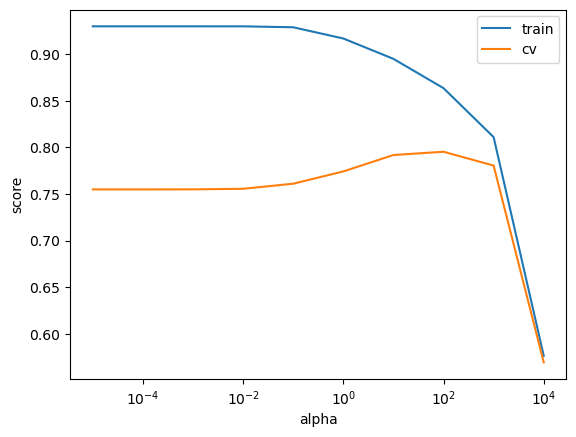

In [41]:
plt.semilogx(param_grid["ridge__alpha"], train_scores.tolist(), label="train")
plt.semilogx(param_grid["ridge__alpha"], cv_scores.tolist(), label="cv")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("score");

In [42]:
best_alpha = search.best_params_
print(best_alpha)
search.best_score_

{'ridge__alpha': 100.0}


0.7951559890417758

In [43]:
pipe_bigalpha = make_pipeline(preprocessor, Ridge(alpha=1000))
pipe_bigalpha.fit(X_train, y_train)
bigalpha_coeffs = pipe_bigalpha.named_steps["ridge"].coef_
pd.DataFrame(
    data=bigalpha_coeffs, index=new_columns, columns=["Coefficients"]
).sort_values(by="Coefficients", ascending=False)

,Coefficients
OverallQual,9691.378159
GrLivArea,7816.490033
1stFlrSF,5931.401623
TotRmsAbvGrd,5209.377032
GarageCars,5057.215412
...,...
SaleType_WD,-1214.532034
GarageFinish_Unf,-1281.596864
Foundation_CBlock,-1766.048889
RoofStyle_Gable,-1985.253914


In [44]:
pipe_smallalpha = make_pipeline(preprocessor, Ridge(alpha=0.01))
pipe_smallalpha.fit(X_train, y_train)
smallalpha_coeffs = pipe_smallalpha.named_steps["ridge"].coef_
pd.DataFrame(
    data=smallalpha_coeffs, index=new_columns, columns=["Coefficients"]
).sort_values(by="Coefficients", ascending=False)

,Coefficients
RoofMatl_WdShngl,128384.117412
RoofMatl_Membran,127326.497787
RoofMatl_Metal,106023.481515
Condition2_PosA,83437.787574
RoofMatl_CompShg,70568.838951
...,...
Exterior1st_ImStucc,-34441.626206
Heating_OthW,-34806.290424
Condition2_RRAe,-63362.335309
Condition2_PosN,-194985.470060


In [45]:
pipe_bestalpha = make_pipeline(
    preprocessor, Ridge(alpha=search.best_params_["ridge__alpha"])
)
pipe_bestalpha.fit(X_train, y_train)
bestalpha_coeffs = pipe_bestalpha.named_steps["ridge"].coef_
pd.DataFrame(
    data=bestalpha_coeffs, index=new_columns, columns=["Coefficients"]
).sort_values(by="Coefficients", ascending=False)

,Coefficients
OverallQual,14485.526602
GrLivArea,11693.792577
Neighborhood_NridgHt,9661.926657
Neighborhood_NoRidge,9492.921850
BsmtQual,8076.988901
...,...
RoofMatl_ClyTile,-3991.413796
LandContour_Bnk,-5002.470666
Neighborhood_Gilbert,-5212.984664
Neighborhood_CollgCr,-5461.450739


### `RidgeCV`

Because it's so common to want to tune `alpha` with `Ridge`, sklearn provides a class called `RidgeCV`, which automatically tunes `alpha` based on cross-validation.

In [46]:
alphas = 10.0 ** np.arange(-6, 6, 1)
ridgecv_pipe = make_pipeline(preprocessor, RidgeCV(alphas=alphas, cv=10))
ridgecv_pipe.fit(X_train, y_train);

In [49]:
best_alpha = ridgecv_pipe.named_steps["ridgecv"].alpha_
best_alpha

100.0

### Exploring the model

In [51]:
ridge_tuned = make_pipeline(preprocessor, Ridge(alpha=best_alpha))
ridge_tuned.fit(X_train, y_train)
ridge_preds = ridge_tuned.predict(X_test)
ridge_preds[:10]

array([228603.06797961, 104643.99931883, 155624.61029914, 246332.07245741,
       127614.33726089, 243243.60429913, 304784.87844893, 145425.67512181,
       157008.6526853 , 128528.91515735])

In [53]:
df = pd.DataFrame(
    data={"coefficients": ridge_tuned.named_steps["ridge"].coef_}, index=new_columns
)
df.sort_values("coefficients", ascending=False)

,coefficients
OverallQual,14485.526602
GrLivArea,11693.792577
Neighborhood_NridgHt,9661.926657
Neighborhood_NoRidge,9492.921850
BsmtQual,8076.988901
...,...
RoofMatl_ClyTile,-3991.413796
LandContour_Bnk,-5002.470666
Neighborhood_Gilbert,-5212.984664
Neighborhood_CollgCr,-5461.450739


### iClicker Exercise 10.1

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select all of the following statements which are TRUE.**

- (A) Price per square foot would be a good feature to add in our `X`. 
- (B) The `alpha` hyperparameter of `Ridge` has similar interpretation of `C` hyperparameter of `LogisticRegression`; higher `alpha` means more complex model. 
- (C) In `Ridge`, smaller alpha means bigger coefficients whereas bigger alpha means smaller coefficients.  

## Regression scoring functions

- We aren't doing classification anymore, so we can't just check for equality:

In [54]:
ridge_tuned.predict(X_train) == y_train

302     False
767     False
429     False
1139    False
558     False
        ...  
1041    False
1122    False
1346    False
1406    False
1389    False
Name: SalePrice, Length: 1314, dtype: bool

We need a score that reflects how right/wrong each prediction is.

A number of popular scoring functions for regression. We are going to look at some common metrics: 

- mean squared error (MSE)
- $R^2$
- root mean squared error (RMSE)
- MAPE

See [sklearn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) for more details. 

### Mean squared error (MSE)

- A common metric is mean squared error:

In [57]:
preds = ridge_tuned.predict(X_train)
np.mean((y_train - preds) ** 2)

872961060.7986538

Perfect predictions would have MSE=0.

In [59]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train, preds)

872961060.7986538

- MSE looks huge and unreasonable. There is an error of ~\$1 Billion!
- Is this score good or bad?

- Unlike classification, with regression **our target has units**. 
- The target is in dollars, the mean squared error is in $dollars^2$ 
- The score also depends on the scale of the targets. 
- If we were working in cents instead of dollars, our MSE would be $10,000 \times (100^2$) higher!

In [60]:
np.mean((y_train * 100 - preds * 100) ** 2)

8729610607986.539

### Root mean squared error or RMSE

- The MSE above is in $dollars^2$.
- A more relatable metric would be the root mean squared error, or RMSE

In [61]:
np.sqrt(mean_squared_error(y_train, ridge_tuned.predict(X_train)))

29545.914451894256

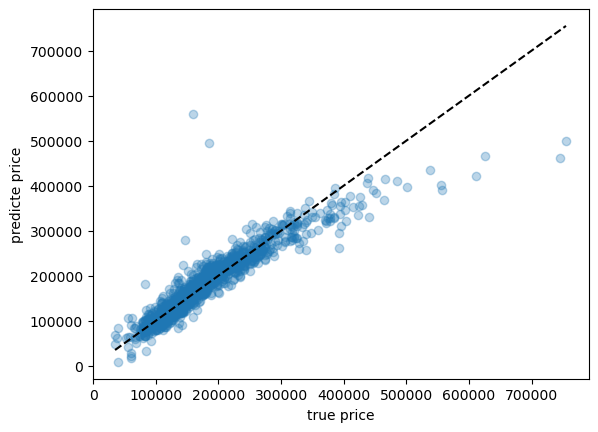

In [62]:
plt.scatter(y_train, ridge_tuned.predict(X_train), alpha=0.3)
grid = np.linspace(y_train.min(), y_train.max(), 1000)
plt.plot(grid, grid, "--k")
plt.xlabel("true price")
plt.ylabel("predicte price");

- Here we can see a few cases where our prediction is way off.
- Is there something weird about those houses, perhaps? Outliers? 
- Under the line means we're under-predicting, over the line means we're over-predicting.

### $R^2$ (not in detail)

A common score is the $R^2$

- This is the score that `sklearn` uses by default when you call score()
- You can [read about it](https://en.wikipedia.org/wiki/Coefficient_of_determination) if interested.
- $R^2$ measures the proportion of variability in $y$ that can be explained using $X$. 
- Independent of the scale of $y$. So the max is 1.  

$$R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y_i})^2}{\sum_{i=1}^n (y_i - \bar{y})^2}$$

- The denominator measures the total variance in $y$.  
- The amount of variability that is left unexplained after performing regression.

Key points:
- The maximum is 1 for perfect predictions
- Negative values are very bad: "worse than DummyRegressor" (very bad)


### MAPE

- We got an RMSE of ~$30,000 before. 

Question: Is an error of \$30,000 acceptable?

- For a house worth \$600k, it seems reasonable! That's 5% error.
- For a house worth \$60k, that is terrible. It's 50% error.

We have both of these cases in our dataset.

How about looking at percent error? 

In [68]:
pred_train = ridge_tuned.predict(X_train)
percent_errors = (pred_train - y_train) / y_train * 100.0
percent_errors[:4]

302      3.839225
767     11.558889
429      8.560768
1139   -16.405650
Name: SalePrice, dtype: float64

These are both positive (predict too high) and negative (predict too low).

We can look at the absolute percent error:

In [69]:
np.abs(percent_errors)[:4]

302      3.839225
767     11.558889
429      8.560768
1139    16.405650
Name: SalePrice, dtype: float64

And, like MSE, we can take the average over examples. This is called mean absolute percent error (MAPE).

In [70]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(y_train, pred_train)

0.10092665203438765

- Ok, this is quite interpretable.
- On average, we have around 10% error.

### Transforming the targets

- When you have prices or count data, the target values are skewed. 
- Let's look at our target column. 

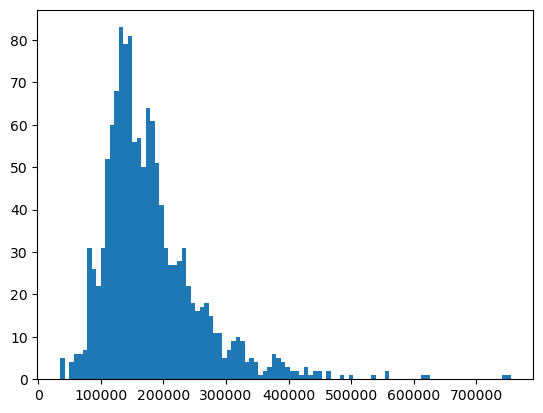

In [72]:
plt.hist(y_train, bins=100);

### Log transform

- A common trick in such cases is applying a log transform on the target column to make it more normal and less skewed.  
- That is, transform $y\rightarrow \log(y)$.
- Linear regression will usually work better on something that looks more normal. 

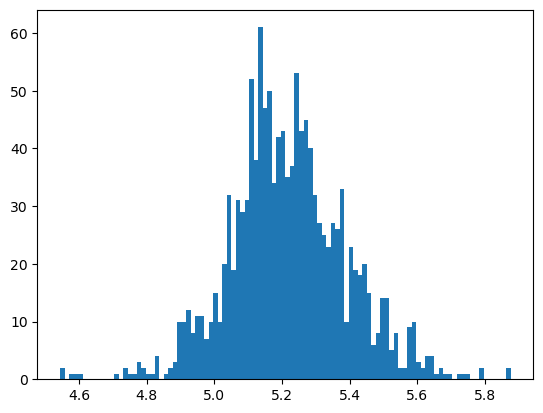

In [73]:
plt.hist(np.log10(y_train), bins=100);

We can incorporate this in our pipeline using `sklearn`. 

In [ ]:
from sklearn.compose import TransformedTargetRegressor

In [74]:
ttr = TransformedTargetRegressor(
    Ridge(alpha=best_alpha), func=np.log1p, inverse_func=np.expm1
) # transformer for log transforming the target
ttr_pipe = make_pipeline(preprocessor, ttr)

In [75]:
ttr_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('drop', 'drop', ['Id']),
                                                 ('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['BedroomAbvGr',
                                                   'KitchenAbvGr',
                                                   'LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'Bs...
                                                   'LotConfig', 'Condition1',
                                                   'GarageType', 'MSZoning',
                                                   'Neighborhood', 'PavedDrive',
                                                   'Exterior1st', 'HouseStyle',
                                                   'BldgType', 'MSSubClass',
                                                   'LandContour', 'Condition2',
                                                   'Street', 'Heating',
                                                   'MasVnrType', 'LotShape',
                                                   'MiscFeature'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=Ridge(alpha=100.0)))])

In [76]:
ttr_pipe.fit(X_train, y_train); # y_train automatically transformed

In [77]:
ttr_pipe.predict(X_train)  # predictions automatically un-transformed

array([221329.43833466, 170670.12761659, 182639.31984311, ...,
       248609.60023631, 132158.15026771, 133270.71866979])

In [78]:
mean_absolute_percentage_error(y_test, ttr_pipe.predict(X_test))

0.07808506982896271

### Different scoring functions with `cross_validate`

- Let's try using MSE instead of the default $R^2$ score. 

In [81]:
pd.DataFrame(
    cross_validate(
        ridge_tuned,
        X_train,
        y_train,
        return_train_score=True,
        scoring="neg_mean_squared_error",
    )
)

,fit_time,score_time,test_score,train_score
0,0.060774,0.014485,-7.055915e+08,-9.379875e+08
1,0.044057,0.015128,-1.239944e+09,-8.264283e+08
2,0.056147,0.017244,-1.125440e+09,-8.758062e+08
3,0.057571,0.017661,-9.801219e+08,-8.849438e+08
4,0.054868,0.019622,-2.267612e+09,-7.395282e+08


In [85]:
def my_mape(true, pred):
    return np.mean(np.abs((pred - true) / true))

# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(my_mape, greater_is_better=False)

pd.DataFrame(
    cross_validate(
        ridge_tuned, X_train, y_train, return_train_score=True, scoring=mape_scorer
    )
)

,fit_time,score_time,test_score,train_score
0,0.043319,0.016612,-0.096960,-0.104070
1,0.049357,0.017264,-0.107985,-0.099685
2,0.051594,0.018558,-0.118347,-0.101796
3,0.054037,0.018914,-0.107947,-0.102435
4,0.053900,0.019645,-0.121985,-0.098307


If you are finding `greater_is_better=False` argument confusing, here is the documentation: 

> greater_is_better(bool), default=True
Whether score_func is a score function (default), meaning high is good, or a loss function, meaning low is good. In the latter case, the scorer object will sign-flip the outcome of the score_func.

Since our custom scorer `mape` gives an error and not a score, I'm passing `False` to it and it'll sign flip so that we can interpret bigger numbers as better performance.  

In [86]:
scoring = {
    "r2": "r2",
    "mape_scorer": mape_scorer, # just for demonstration for a custom scorer
    "sklearn MAPE": "neg_mean_absolute_percentage_error",
    "neg_root_mean_square_error": "neg_root_mean_squared_error",
    "neg_mean_squared_error": "neg_mean_squared_error",
}

pd.DataFrame(
    cross_validate(
        ridge_tuned, X_train, y_train, return_train_score=True, scoring=scoring
    )
).T

,0,1,2,3,4
fit_time,4.188538e-02,5.373693e-02,5.601454e-02,5.857635e-02,6.234694e-02
score_time,1.883221e-02,2.071810e-02,2.141094e-02,2.247453e-02,2.259064e-02
test_r2,8.669805e-01,8.200326e-01,8.262156e-01,8.514598e-01,6.110915e-01
train_r2,8.551862e-01,8.636849e-01,8.580539e-01,8.561645e-01,8.834356e-01
test_mape_scorer,-9.696034e-02,-1.079852e-01,-1.183471e-01,-1.079471e-01,-1.219845e-01
train_mape_scorer,-1.040698e-01,-9.968514e-02,-1.017959e-01,-1.024351e-01,-9.830712e-02
test_sklearn MAPE,-9.696034e-02,-1.079852e-01,-1.183471e-01,-1.079471e-01,-1.219845e-01
train_sklearn MAPE,-1.040698e-01,-9.968514e-02,-1.017959e-01,-1.024351e-01,-9.830712e-02
test_neg_root_mean_square_error,-2.656297e+04,-3.521284e+04,-3.354759e+04,-3.130690e+04,-4.761945e+04
train_neg_root_mean_square_error,-3.062658e+04,-2.874767e+04,-2.959402e+04,-2.974801e+04,-2.719427e+04


### Are we getting the same `alpha` with mape? 

In [88]:
param_grid = {"ridge__alpha": 10.0 ** np.arange(-6, 6, 1)}
pipe_ridge = make_pipeline(preprocessor, Ridge())
search = GridSearchCV(
    pipe_ridge, param_grid, return_train_score=True, n_jobs=-1, scoring=mape_scorer
)
search.fit(X_train, y_train);

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarn

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarn

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarn

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed 

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarn

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarn

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-pac

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: Fut

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarn

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarn

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: Fut

In [89]:
print("Best hyperparameter values: ", search.best_params_)
print("Best score: %0.3f" % (search.best_score_))
pd.DataFrame(search.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_ridge__alpha",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

Best hyperparameter values:  {'ridge__alpha': 100.0}
Best score: -0.111


rank_test_score,1,2,3,4,5,6,7,8,9,10,11,12
mean_train_score,-0.101259,-0.111543,-0.096462,-0.090785,-0.085698,-0.085508,-0.085546,-0.08555,-0.085551,-0.085551,-0.203421,-0.33213
mean_test_score,-0.110645,-0.115401,-0.116497,-0.122331,-0.125644,-0.127242,-0.127418,-0.127439,-0.127441,-0.127441,-0.204692,-0.33271
param_ridge__alpha,100.0,1000.0,10.0,1.0,0.1,0.01,0.001,0.0001,0.00001,0.000001,10000.0,100000.0
mean_fit_time,0.210788,0.184239,0.167727,0.159614,0.142819,0.149816,0.164537,0.162199,0.223614,0.247593,0.156414,0.147402


### Using multiple metrics in `GridSearchCV` or `RandomizedSearchCV` 

- We could use multiple metrics with `GridSearchCV` or `RandomizedSearchCV`. 
- But if you do so, you need to set `refit` to the metric (string) for which the `best_params_` will be found and used to build the `best_estimator_` on the whole dataset. 

In [90]:
search_multi = GridSearchCV(
    pipe_ridge,
    param_grid,
    return_train_score=True,
    n_jobs=-1,
    scoring=scoring,
    refit="mape_scorer",
)
search_multi.fit(X_train, y_train);

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarn

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarn

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarn

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-pac

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarn

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarn

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarn

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarn

/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/andrew/.install/opt/mamba/envs/cpsc330/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed 

In [91]:
print("Best hyperparameter values: ", search_multi.best_params_)
print("Best score: %0.3f" % (search_multi.best_score_))
pd.DataFrame(search_multi.cv_results_).set_index("rank_test_mape_scorer").sort_index()

Best hyperparameter values:  {'ridge__alpha': 100.0}
Best score: -0.111


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,...,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_train_neg_mean_squared_error,split1_train_neg_mean_squared_error,split2_train_neg_mean_squared_error,split3_train_neg_mean_squared_error,split4_train_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error
rank_test_mape_scorer,,,,,,,,,,,,,,,,,,,,,
1,0.221239,0.076100,0.059680,0.014826,100.0,{'ridge__alpha': 100.0},0.866980,0.820033,0.826216,0.851460,...,-1.263742e+09,5.328077e+08,1,-9.379875e+08,-8.264283e+08,-8.758062e+08,-8.849438e+08,-7.395282e+08,-8.529388e+08,6.685103e+07
2,0.134844,0.017183,0.061833,0.023744,1000.0,{'ridge__alpha': 1000.0},0.827261,0.786555,0.802902,0.812272,...,-1.362185e+09,3.262269e+08,3,-1.282021e+09,-1.156311e+09,-1.207814e+09,-1.225301e+09,-1.029950e+09,-1.180279e+09,8.521743e+07
3,0.162491,0.067541,0.066943,0.018016,10.0,{'ridge__alpha': 10.0},0.859318,0.820564,0.832866,0.846650,...,-1.283119e+09,5.511620e+08,2,-7.034979e+08,-6.276943e+08,-6.910456e+08,-6.701186e+08,-5.915714e+08,-6.567856e+08,4.155178e+07
4,0.152610,0.036617,0.058994,0.014690,1.0,{'ridge__alpha': 1.0},0.835749,0.810073,0.831611,0.843992,...,-1.386071e+09,6.378971e+08,4,-5.394113e+08,-4.898703e+08,-5.405227e+08,-5.290961e+08,-5.046193e+08,-5.207039e+08,2.011269e+07
5,0.144427,0.019008,0.047254,0.011434,0.1,{'ridge__alpha': 0.1},0.821807,0.792828,0.805198,0.863941,...,-1.465279e+09,6.931439e+08,5,-4.579559e+08,-4.009514e+08,-4.345386e+08,-4.515351e+08,-4.846260e+08,-4.459214e+08,2.766317e+07
6,0.140159,0.026755,0.047667,0.005943,0.01,{'ridge__alpha': 0.01},0.824884,0.782183,0.787933,0.868003,...,-1.501304e+09,7.090376e+08,6,-4.522563e+08,-3.926733e+08,-4.251158e+08,-4.446284e+08,-4.837022e+08,-4.396752e+08,3.014081e+07
7,0.121924,0.017088,0.039337,0.002473,0.001,{'ridge__alpha': 0.001},0.826553,0.780497,0.785399,0.868281,...,-1.505592e+09,7.117899e+08,7,-4.521578e+08,-3.925288e+08,-4.249618e+08,-4.445124e+08,-4.836880e+08,-4.395697e+08,3.018459e+07
8,0.137395,0.029825,0.043341,0.005763,0.0001,{'ridge__alpha': 0.0001},0.826739,0.780316,0.785134,0.868305,...,-1.506035e+09,7.120769e+08,8,-4.521567e+08,-3.925272e+08,-4.249601e+08,-4.445111e+08,-4.836878e+08,-4.395686e+08,3.018507e+07
9,0.141502,0.039470,0.056071,0.022120,0.00001,{'ridge__alpha': 1e-05},0.826758,0.780298,0.785108,0.868308,...,-1.506079e+09,7.121056e+08,9,-4.521567e+08,-3.925272e+08,-4.249601e+08,-4.445111e+08,-4.836878e+08,-4.395686e+08,3.018507e+07


In [92]:
search_multi.score(X_test, y_test)

-0.09503409246217497

### Using regression metrics with `scikit-learn`

- In `sklearn`, you will notice that it has negative version of the metrics above (e.g., `neg_mean_squared_error`, `neg_root_mean_squared_error`). 
- The reason for this is that scores return a value to maximize, the higher the better.

### iClicker Exercise 10.2

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select all of the following statements which are TRUE.**

- (A) We can use still use precision and recall for regression problems but now we have other metrics we can use as well.
- (B) In `sklearn` for regression problems, using `r2_score()` and `.score()` (with default values) will produce the same results.
- (C) RMSE is always going to be non-negative.
- (D) MSE does not directly provide the information about whether the model is underpredicting or overpredicting.
- (E) We can pass multiple scoring metrics to `GridSearchCV` or `RandomizedSearchCV` for regression as well as classification problems. 

## What did we learn today? 

- House prices dataset target is price, which is numeric -> regression rather than classification
- There are corresponding versions of all the tools we used:
    - `DummyClassifier` -> `DummyRegressor`
    - `LogisticRegression` -> `Ridge`
- `Ridge` hyperparameter `alpha` is like `LogisticRegression` hyperparameter `C`, but opposite meaning
- We'll avoid `LinearRegression` in this course.

- Scoring metrics
- $R^2$ is the default .score(), it is unitless, 0 is bad, 1 is best
- MSE (mean squared error) is in units of target squared, hard to interpret; 0 is best
- RMSE (root mean squared error) is in the same units as the target; 0 is best
- MAPE (mean absolute percent error) is unitless; 0 is best, 1 is bad